In [43]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from concurrent.futures import ThreadPoolExecutor



Path to dataset files: /root/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [ ]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

In [49]:
data = pd.read_csv(path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [50]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [51]:
data.duplicated().sum()

np.int64(0)

In [52]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [53]:
data = data.drop("customerID", axis = 1)

In [54]:
data[data['TotalCharges'] == '']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [55]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors = 'coerce')

In [56]:
data['TotalCharges'] = data['TotalCharges'].replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset = ['TotalCharges'])

In [57]:
data.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


In [58]:
print(data.select_dtypes(exclude = ['number']).columns)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')


In [59]:
from concurrent.futures.thread import ThreadPoolExecutor
def process_cols(data):
  for col in data.select_dtypes(include = 'number').columns:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    IQR = q3 - q1
    outliers = data[(data[col] < (q1 - 1.5 * IQR)) | (data[col] > (q3 + 1.5 * IQR))]
    if len(outliers) > 0:
      print(f"{col} - Outliers: {len(outliers)}")
      print(outliers[[col]])
      print("====================================")

def outliers(data):
  numeric_cols = data.select_dtypes(include = ['number']).columns
  with ThreadPoolExecutor() as executor:
    executor.map(process_cols, data[numeric_cols])

In [60]:
outliers(data)

In [61]:
data[data["tenure"] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [62]:
data.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [69]:
def plot_dist(data):
  numeric_cols = data.select_dtypes(include = ['number']).columns

  num_cols = len(numeric_cols)
  num_rows = (num_cols // 3) + 1

  plt.figure(figsize = (12, 4 * num_rows))

  for i, col in enumerate(numeric_cols, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(df[col], kde = True, color = 'blue', bins = 30)
    plt.title(f'Distribution of {col}', fontsize = 10)
    plt.xlabel(col)
    plt.ylabel('Frequency')

  plt.tight_layout()
  plt.show()

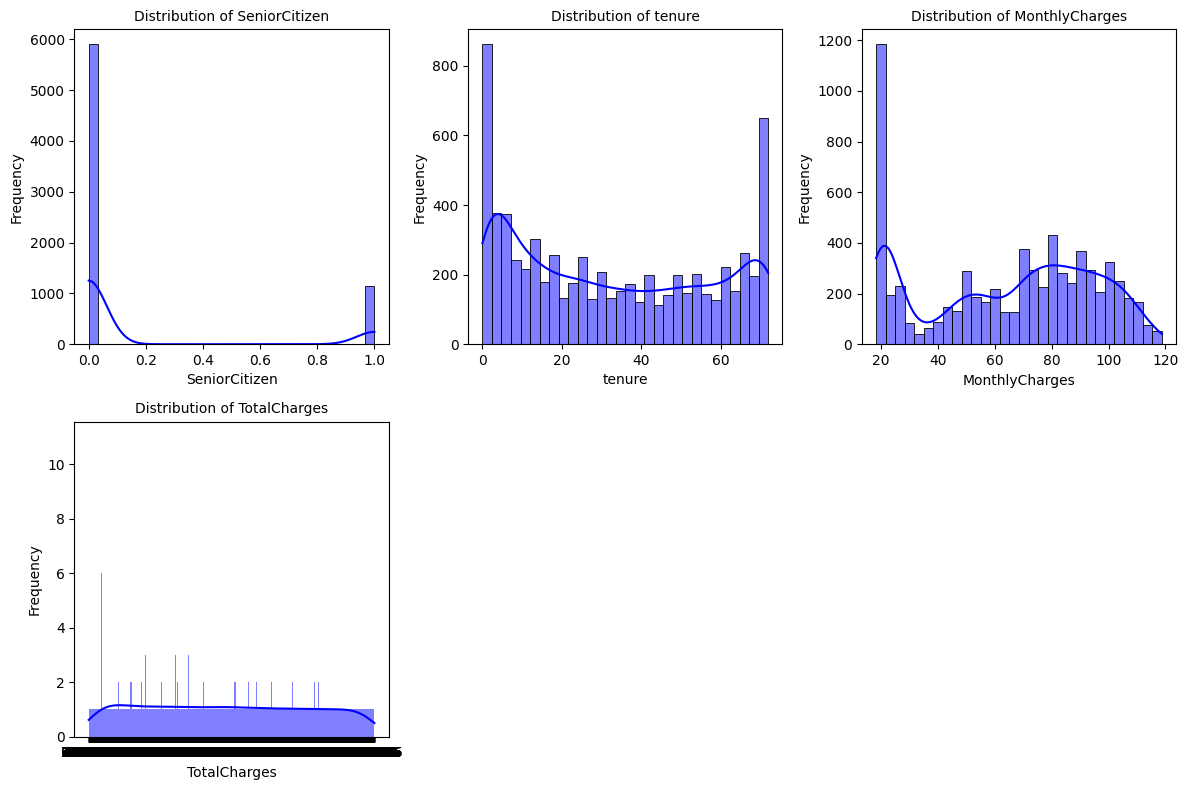

In [70]:
plot_dist(data)

In [80]:
def plot_bars(data, max_unique = 30):
  categorical_cols = [
      col for col in data.select_dtypes(include=['object', 'category']).columns
      if data[col].nunique() < max_unique
  ]
  num_cols = len(categorical_cols)

  if num_cols == 0:
    return

  num_rows = math.ceil(num_cols / 3)
  num_cols = min(num_cols, 3)

  fig, axes = plt.subplots(num_rows, num_cols, figsize = (12, 4 * num_rows))
  axes = axes.flatten()

  for i, col in enumerate(categorical_cols):
    data[col].value_counts().plot.bar(
        ax = axes[i],
        color = 'blue',
        edgecolor = 'black'
    )
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Categories')

  for j in range(i +1, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


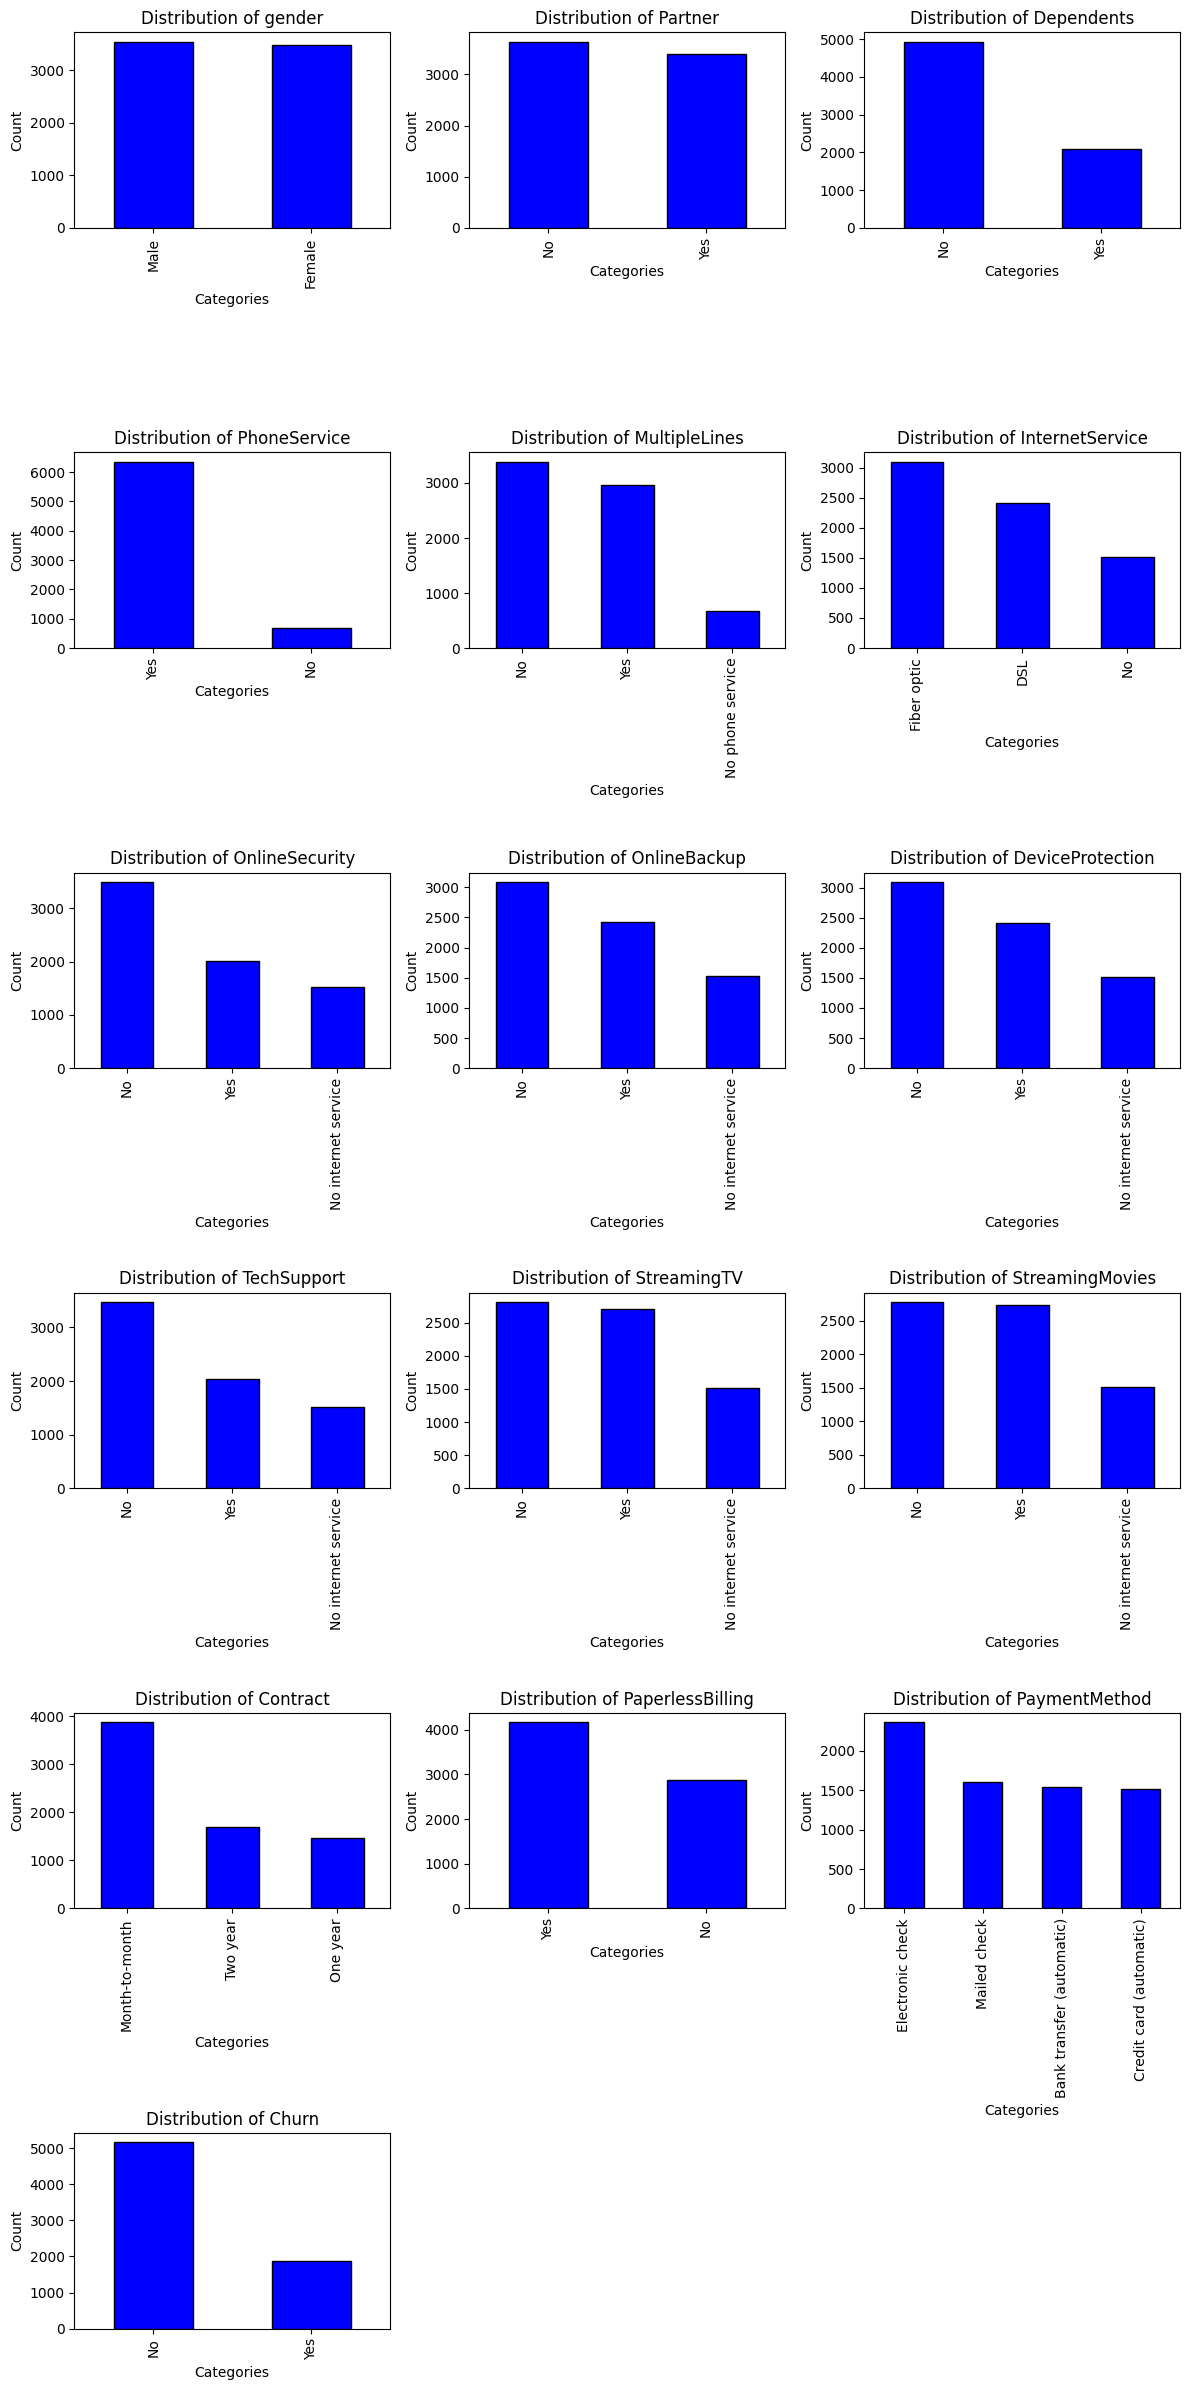

In [81]:
plot_bars(data)

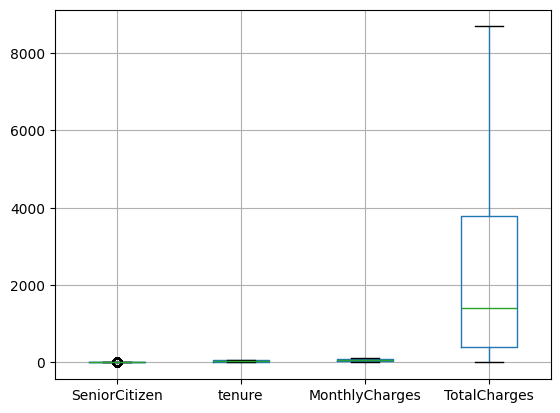

In [82]:
data.boxplot()
plt.show()